In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Path to your CSV file
file_path = 'ciciot-2023.csv'

# Read the CSV file, and immediately change float64 columns to float32
df = pd.read_csv(file_path).astype({col: 'float32' for col in pd.read_csv(file_path, nrows=1).select_dtypes(include=['float64']).columns})

# Now df contains the data from the CSV file with float64 columns converted to float32

In [4]:
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() < df.shape[0] * 0.5:  # Threshold for conversion
        df[col] = df[col].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 28098546 entries, 0 to 28098545

Data columns (total 37 columns):

 #   Column           Dtype   

---  ------           -----   

 0   flow_duration    float32 

 1   Header_Length    float32 

 2   Protocol Type    float32 

 3   Duration         float32 

 4   Rate             float32 

 5   Srate            float32 

 6   fin_flag_number  float32 

 7   syn_flag_number  float32 

 8   rst_flag_number  float32 

 9   psh_flag_number  float32 

 10  ack_flag_number  float32 

 11  ack_count        float32 

 12  syn_count        float32 

 13  fin_count        float32 

 14  urg_count        float32 

 15  rst_count        float32 

 16  HTTP             float32 

 17  HTTPS            float32 

 18  TCP              float32 

 19  UDP              float32 

 20  ICMP             float32 

 21  IPv              float32 

 22  LLC              float32 

 23  Tot sum          float32 

 24  Min              float32 

 25  Max          

In [6]:
df['label'] = df['label'].str.replace('DDoS-UDP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SynonymousIP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-UDP_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-TCP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SYN_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ICMP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-PSHACK_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-RSTFINFlood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ICMP_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SlowLoris', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ACK_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-HTTP_Flood', 'DDoS')

df['label'] = df['label'].str.replace('DoS-TCP_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-UDP_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-SYN_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-HTTP_Flood', 'DoS')

df['label'] = df['label'].str.replace('Recon-HostDiscovery', 'Recon')
df['label'] = df['label'].str.replace('Recon-OSScan', 'Recon')
df['label'] = df['label'].str.replace('VulnerabilityScan', 'Recon')
df['label'] = df['label'].str.replace('Recon-PortScan', 'Recon')
df['label'] = df['label'].str.replace('Recon-PingSweep', 'Recon')

df['label'] = df['label'].str.replace('XSS', 'Web-Based')
df['label'] = df['label'].str.replace('Uploading_Attack', 'Web-Based')
df['label'] = df['label'].str.replace('BrowserHijacking', 'Web-Based')
df['label'] = df['label'].str.replace('SqlInjection', 'Web-Based')
df['label'] = df['label'].str.replace('CommandInjection', 'Web-Based')
df['label'] = df['label'].str.replace('Backdoor_Malware', 'Web-Based')

df['label'] = df['label'].str.replace('DictionaryBruteForce', 'Brute_Force')

df['label'] = df['label'].str.replace('MITM-ArpSpoofing', 'Spoofing')
df['label'] = df['label'].str.replace('DNS_Spoofing', 'Spoofing')

df['label'] = df['label'].str.replace('Mirai-greip_flood', 'Mirai')
df['label'] = df['label'].str.replace('Mirai-greeth_flood', 'Mirai')
df['label'] = df['label'].str.replace('Mirai-udpplain', 'Mirai')

df['label'] = df['label'].str.replace('BenignTraffic', 'Normal')

In [7]:
print(df['label'].value_counts())

label

DDoS           17567556

DoS             6440023

Mirai           2114210

Normal          1098177

Spoofing         486464

Recon            354223

Web-Based         24829

Brute_Force       13064

Name: count, dtype: int64


In [8]:
# Creating a dictionary of Types
attacks = {'DDoS':0, 'DoS':1, 'Recon':2, 'Web-Based':3,
           'Brute_Force':4, 'Spoofing':5, 'Mirai':6, 'Normal':7}
df['label'] = df['label'].map(attacks)

In [9]:
X = df.drop(columns=['label'])
y = df['label']

In [10]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the original training data for simple validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [12]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Extra Trees model

In [22]:
# Initialize the Extra Trees classifier with default parameters
extra_trees = ExtraTreesClassifier()

# Record the start time for training
start_time = time.time()

# Fit the model on the training data
extra_trees.fit(X_train, y_train)

# Calculate and print the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.3f} seconds')

# Record the start time for prediction
start_time = time.time()

# Make predictions on the test data
y_pred = extra_trees.predict(X_test)

# Calculate and print the testing time
testing_time = time.time() - start_time
print(f'Testing Time: {testing_time:.3f} seconds')

Training Time: 4217.905 seconds

Testing Time: 201.462 seconds


In [24]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9932

Precision: 0.9539

Recall: 0.8111

F1 Score: 0.8555


In [25]:
# Find the unique labels in your test set
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter your attacks dictionary to only include keys with values present in unique_labels
filtered_attacks = {k: v for k, v in attacks.items() if v in unique_labels}

# Now use the filtered attack names as target_names in your classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=list(filtered_attacks.values()), target_names=list(filtered_attacks.keys())))

Classification Report:

              precision    recall  f1-score   support



        DDoS       1.00      1.00      1.00   3513485

         DoS       1.00      1.00      1.00   1287718

       Recon       0.91      0.82      0.87     71339

   Web-Based       0.95      0.48      0.63      4929

 Brute_Force       0.94      0.36      0.52      2556

    Spoofing       0.92      0.86      0.89     97212

       Mirai       1.00      1.00      1.00    422393

      Normal       0.91      0.98      0.94    220078



    accuracy                           0.99   5619710

   macro avg       0.95      0.81      0.86   5619710

weighted avg       0.99      0.99      0.99   5619710




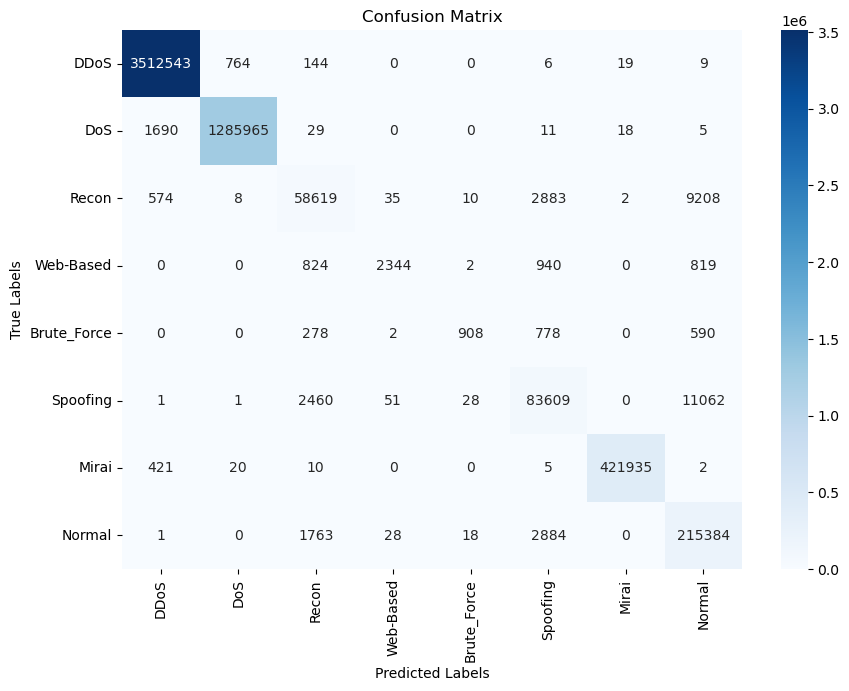

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attacks.keys(), yticklabels=attacks.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

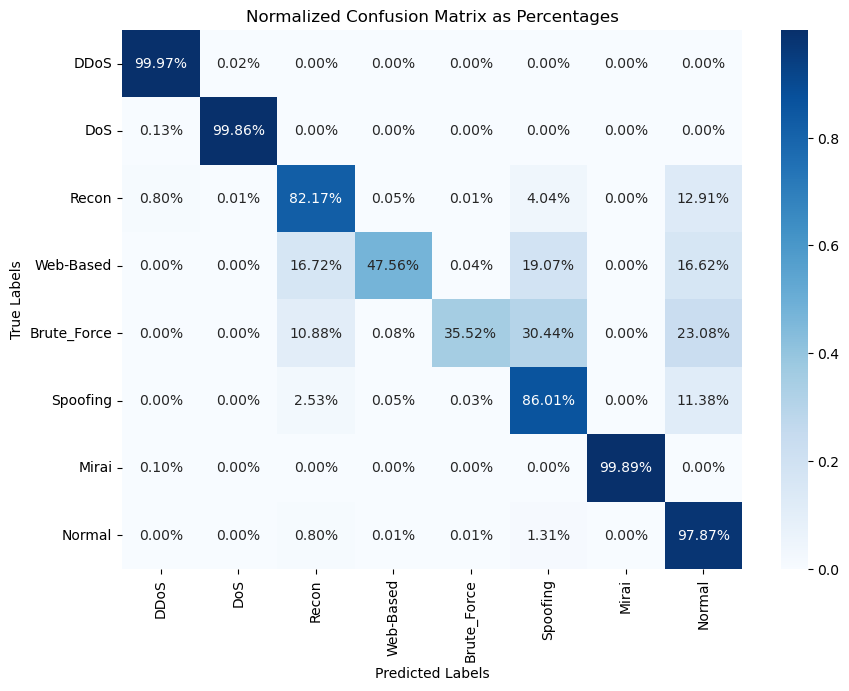

In [27]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()

# Hyperparameters Optimization

In [25]:
def objective_function(hyperparameters, X_train, y_train, X_val, y_val):
     # Ensure parameter values are within valid ranges
     n_estimators = max(int(hyperparameters[0]), 10)  # Ensuring n_estimators is at least 10
     max_depth = None if hyperparameters[1] < 0 else max(int(hyperparameters[1]), 1)
     min_samples_split = max(int(hyperparameters[2]), 2)
     min_samples_leaf = max(int(hyperparameters[3]), 1)
     max_features = map_max_features(hyperparameters[4])  # Use mapped value
     bootstrap = hyperparameters[5] > 0.5  # Convert to boolean

     model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  max_features=max_features, bootstrap=bootstrap, random_state=42)
    
     model.fit(X_train, y_train)
     y_pred = model.predict(X_val)
     return -accuracy_score(y_val, y_pred)  # Negative accuracy for minimization

# Harmony Search Algorithm

In [26]:
def harmony_search(objective_func, X_train, y_train, X_val, y_val, memory_size=10, n_iter=100, hmcr=0.9, par=0.3, bw=0.01):
     # Initialize Harmony Memory (HM) with valid ranges
     HM = np.random.rand(memory_size, 6)
     # Adjust scales for hyperparameters
     HM[:, 0] = HM[:, 0] * 190 + 10  # n_estimators from 10 to 200
     HM[:, 1] = HM[:, 1] * 19 + 1  # max_depth from 1 to 20
     HM[:, 2] = HM[:, 2] * 9 + 2  # min_samples_split from 2 to 11
     HM[:, 3] = HM[:, 3] * 9 + 1  # min_samples_leaf from 1 to 10
     HM[:, 4] = HM[:, 4]  # max_features will be mapped later
     HM[:, 5] = HM[:, 5] > 0.5  # bootstrap represented as a boolean

     best_score = float('inf')
     best_harmony = None

     for _ in range(n_iter):
         new_harmony = np.zeros(6)
         for i in range(6):
             if np.random.rand() < hmcr:  # Harmony Memory Consideration Rate
                 new_harmony[i] = HM[np.random.randint(0, memory_size), i]
                 if np.random.rand() < par:  # Pitch Adjustment Rate
                     adjustment = bw * (np.random.rand() - 0.5) * 2
                     new_harmony[i] += adjustment if i != 5 else 0  # Avoid adjusting the bootstrap boolean
             else:
                 # Randomly initialize this parameter
                 if i == 5:  # Bootstrap parameter
                     new_harmony[i] = np.random.rand() > 0.5
                 else:
                     new_harmony[i] = np.random.rand()  # Will be scaled accordingly later

         # Ensure new harmony is within valid ranges and scale appropriately
         new_harmony[0] = max(int(new_harmony[0] * 190 + 10), 10)  # n_estimators
         new_harmony[1] = None if new_harmony[1] < 0 else max(int(new_harmony[1] * 19 + 1), 1)  # max_depth
         new_harmony[2] = max(int(new_harmony[2] * 9 + 2), 2)  # min_samples_split
         new_harmony[3] = max(int(new_harmony[3] * 9 + 1), 1)  # min_samples_leaf
         # max_features is handled in the objective function

         score = objective_func(new_harmony, X_train, y_train, X_val, y_val)

         # Update Harmony Memory and best harmony if necessary
         if score < best_score:
             best_score = score
             best_harmony = new_harmony

         # Update Harmony Memory (HM) if the new harmony is better than the worst harmony in HM
         worst_scores = [objective_func(HM[i, :], X_train, y_train, X_val, y_val) for i in range(memory_size)]
         worst_idx = np.argmax(worst_scores)
         if score < worst_scores[worst_idx]:
             HM[worst_idx, :] = new_harmony

     return best_harmony

In [27]:
def map_max_features(value):
    # Assuming 'value' is a continuous variable from 0 to 1 obtained from harmony search
    if value < 0.25:
        return 'sqrt'  # Changed from 'auto' to 'sqrt' to comply with ExtraTreesClassifier specifications
    elif value < 0.5:
        return 'log2'
    elif value < 0.75:
        # Maps to a fraction of features, e.g., 0.5 for half of the features
        return 0.5
    else:
        # Use all features
        return None

# Optimized Extra Trees

In [18]:
start_time = time.time()
# Optimize hyperparameters
best_hyperparams = harmony_search(objective_function, X_train, y_train, X_test, y_test)

# Train the Extra Trees model with optimized hyperparameters
# Use the optimized hyperparameters to configure the Extra Trees model
optimized_model = ExtraTreesClassifier(
    n_estimators=int(best_hyperparams[0]),
    max_depth=None if best_hyperparams[1] < 0 else int(best_hyperparams[1]),
    min_samples_split=int(best_hyperparams[2]),
    min_samples_leaf=int(best_hyperparams[3]),
    max_features=map_max_features(best_hyperparams[4]),  # Ensure this function maps to valid values
    bootstrap=bool(best_hyperparams[5]),
    random_state=42
)
opt_time = time.time() - start_time

print(f'Optimization Time: {opt_time:.3f} seconds')

Optimization Time: 9783.412 seconds


In [19]:
# Assuming 'best_hyperparams' is obtained from the 'harmony_search' function

print(f"n_estimators: {int(best_hyperparams[0])}")
print(f"max_depth: {None if best_hyperparams[1] < 0 else int(best_hyperparams[1])}")
print(f"min_samples_split: {int(best_hyperparams[2])}")
print(f"min_samples_leaf: {int(best_hyperparams[3])}")
print(f"max_features: {best_hyperparams[4]}")  # Assuming this is the raw value used in 'map_max_features'
print(f"bootstrap: {bool(best_hyperparams[5])}")  # Converts to True if non-zero/True, otherwise False

n_estimators: 190

max_depth: 18

min_samples_split: 5

min_samples_leaf: 2

max_features: 0.7937459621047258

bootstrap: True


In [20]:
# Record the start time for training
start_time = time.time()

optimized_model.fit(X_train, y_train)

# Calculate and print the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.3f} seconds')

# Record the start time for prediction
start_time = time.time()

# Evaluate the optimized model
y_pred = optimized_model.predict(X_test)

# Calculate and print the testing time
testing_time = time.time() - start_time
print(f'Testing Time: {testing_time:.3f} seconds')

Training Time: 5491.069 seconds

Testing Time: 74.649 seconds


In [14]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9951

Precision: 0.9602

Recall: 0.8714

F1 Score: 0.9065


In [15]:
# Find the unique labels in your test set
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter your attacks dictionary to only include keys with values present in unique_labels
filtered_attacks = {k: v for k, v in attacks.items() if v in unique_labels}

# Now use the filtered attack names as target_names in your classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=list(filtered_attacks.values()), target_names=list(filtered_attacks.keys())))

Classification Report:

              precision    recall  f1-score   support



        DDoS       1.00      1.00      1.00   3513485

         DoS       1.00      1.00      1.00   1287718

       Recon       0.92      0.87      0.89     71339

   Web-Based       0.94      0.61      0.74      4929

 Brute_Force       0.96      0.62      0.75      2556

    Spoofing       0.93      0.89      0.91     97212

       Mirai       1.00      1.00      1.00    422393

      Normal       0.94      0.98      0.96    220078



    accuracy                           1.00   5619710

   macro avg       0.96      0.87      0.91   5619710

weighted avg       1.00      1.00      1.00   5619710




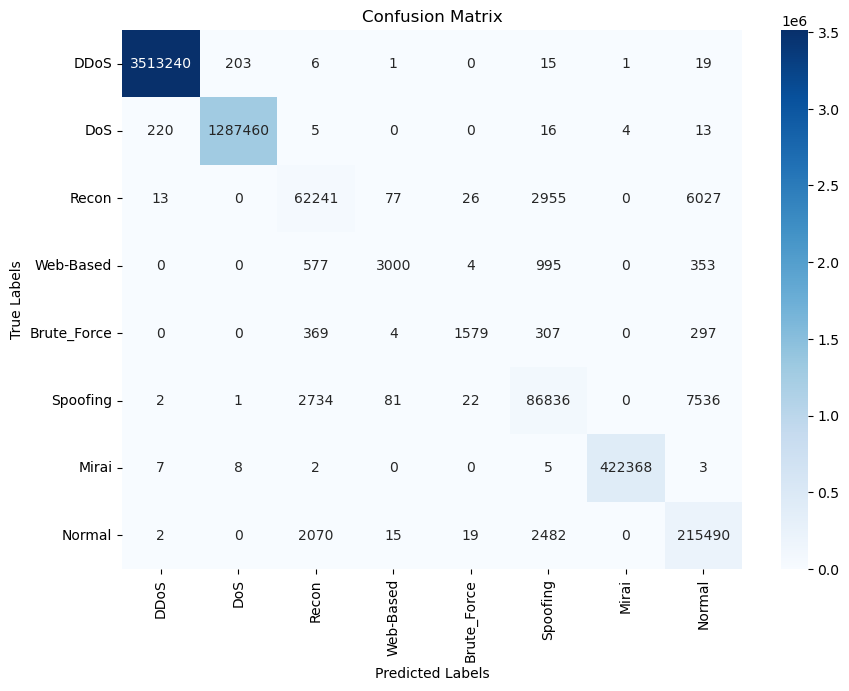

In [16]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attacks.keys(), yticklabels=attacks.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

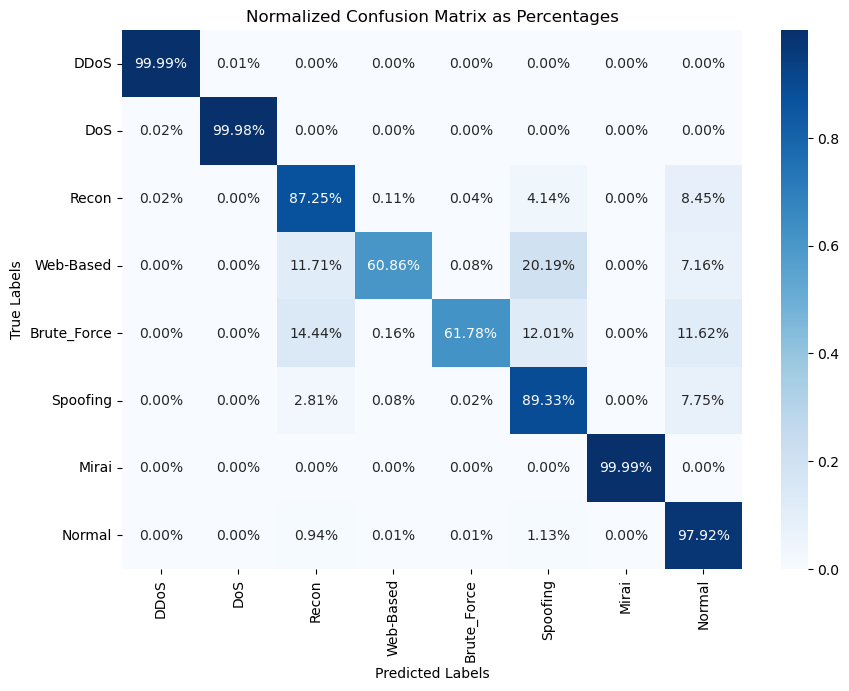

In [17]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()

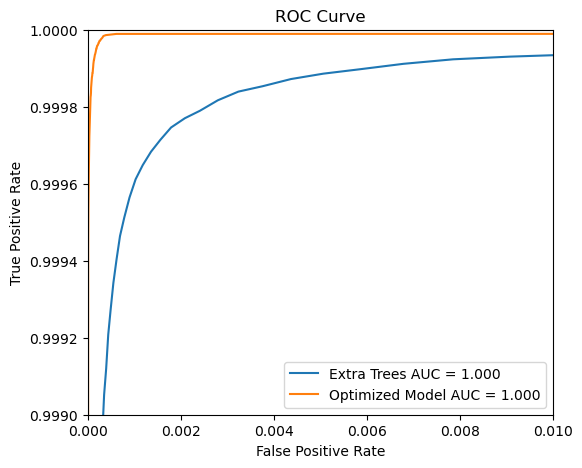

In [34]:
# Replace with the actual class labels from your dataset
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]  # for example

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Assuming you are interested in the performance with respect to class 1
y_prob_extra_trees_class1 = extra_trees.predict_proba(X_test)[:, 1]
y_prob_optimized_class1 = optimized_model.predict_proba(X_test)[:, 1]

# Now you can calculate the ROC curve for class 1
fpr_extra_trees, tpr_extra_trees, _ = roc_curve(y_test_binarized[:, 1], y_prob_extra_trees_class1)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test_binarized[:, 1], y_prob_optimized_class1)

# Calculate the AUC
auc_extra_trees = auc(fpr_extra_trees, tpr_extra_trees)
auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plotting the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_extra_trees, tpr_extra_trees, label=f'Extra Trees AUC = {auc_extra_trees:.3f}')
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Model AUC = {auc_optimized:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for reference

# Focus on the specific region of interest
plt.xlim([0, 0.01])
plt.ylim([0.999, 1.0])

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()